<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/Advanced_Topics/Vision_Transformer_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Notebook by: **Hiroto Honda**

This notebook provides the simple walkthrough of the Vision Transformer by looking at the actual data flow during inference.

- Model Implementation: this notebook loads Ross Wightman's timm module.
- Paper: "An Image is worth 16x16 Words: Transformer for Image Recognition at Scale", Dosovitskiy et al.

In [1]:
%%capture
!pip install timm

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

In [3]:
model_name = 'vit_base_patch16_224'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')
# create a ViT Model: pytorch-image-models/timm
model = create_model(model_name,pretrained=True).to(device)

device = cpu


In [4]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5,0.5,0.5)
NORMALIZE_STD = (0.5,0.5,0.5)
transforms = [
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(NORMALIZE_MEAN,NORMALIZE_STD),             
]
transforms = T.Compose(transforms)

In [5]:
%%capture
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png

In [6]:
img = PIL.Image.open('/content/santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

Inference Result:dome



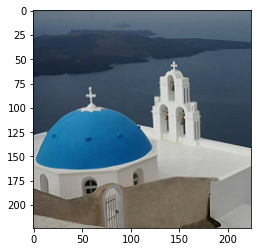

In [7]:
%matplotlib inline
# end to end inference
output = model(img_tensor)
print(f'Inference Result:{imagenet_labels[int(torch.argmax(output))]}')
plt.imshow(img)


**Dig into Vision Transformer**
![](https://camo.githubusercontent.com/04f3a1f011ea493cf633d3b64b7cd5121001c98655818699bb70838edc8a3f3e/68747470733a2f2f6769746875622e636f6d2f6869726f746f6d7573696b65722f736368776572745f636f6c61625f646174615f73746f726167652f626c6f622f6d61737465722f696d616765732f7669745f64656d6f2f7669745f696e7075742e706e673f7261773d74727565)

## 1. Split Image into Patches
The input image is split into N patches(N=14x14 for ViT-Base) and converted to D=768 vectors by learnable 2D convolution.

`Conv2d(3,768,kernel_size=(16,16),stride=(16,16))`

In [8]:
patches = model.patch_embed(img_tensor) # patch embedding convolution
print(f'Image tensor: {img_tensor.shape}')
print(f'Patch embeddings: {patches.shape}')

Image tensor: torch.Size([1, 3, 224, 224])
Patch embeddings: torch.Size([1, 196, 768])


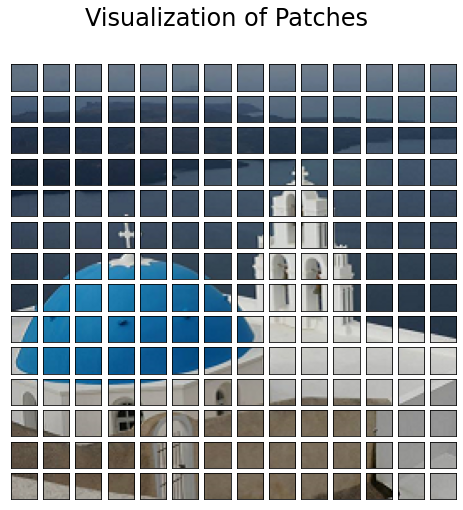

In [9]:
# This is NOT a part of the pipeline.
# Actually, the image is divided into patch embeddings by Conv2d
fig = plt.figure(figsize=(8,8))
fig.suptitle('Visualization of Patches', fontsize=24)
fig.add_axes()
img = np.asarray(img)
for i in range(0, 196):
  x = int(i % 14)
  y = int(i / 14)
  patch = img[y * 16: (y+1)*16, x*16:(x+1)*16]
  ax = fig.add_subplot(14,14,i+1)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.imshow(patch)

## 2. Add Positional Embeddings
To make patches position-aware, learnable position embedding vectors are added to the patch embedding vectors. The position embedding vectors learn distance with the image thus neighbouring ones have high similarity

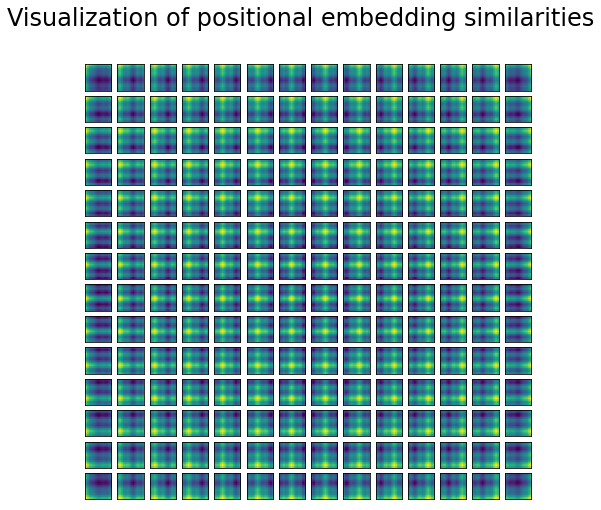

In [10]:
cos = torch.nn.CosineSimilarity(dim=1,eps=1e-6)
fig = plt.figure(figsize=(8,8))
fig.suptitle('Visualization of positional embedding similarities',fontsize=24)
pos_embed = model.pos_embed
for i in range(1, pos_embed.shape[1]):
  sim = F.cosine_similarity(pos_embed[0,i:i+1],pos_embed[0,1:],dim = 1)
  sim = sim.reshape((14,14)).detach().cpu().numpy()
  ax = fig.add_subplot(14,14,i)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.imshow(sim)

**Make Transformer Input**

A learnable class token is prepended to the patch embedding vectors as the 0th vector. 197(= 1 + 14x14) learnable position embedding vectors are adde to tthe patch embedding vectors.

In [11]:
transformer_input = torch.cat((model.cls_token,patches), dim=1) + pos_embed


## 3. Transformer Encoder
![](https://camo.githubusercontent.com/d680008606ecb5d6f0f3dd214781b340c1a3a7ce7a0e325d0a0323f83256dd22/68747470733a2f2f6769746875622e636f6d2f6869726f746f6d7573696b65722f736368776572745f636f6c61625f646174615f73746f726167652f626c6f622f6d61737465722f696d616765732f7669745f64656d6f2f7472616e73666f726d65725f656e636f6465722e706e673f7261773d74727565)

**Series Transformer Encoders**

In [12]:
print(f'Input tensor to Transformer (z0): {transformer_input.shape}')
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
  print(f'Entering the Transformer Encoder {i}')
  x = blk(x)
x = model.norm(x)
transformer_output = x[:,0]
print(f'Output vector from Transformer (z12-0): {transformer_output.shape}')

Input tensor to Transformer (z0): torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


**How Attention Works**

In [13]:
print(f'Transformer Multi-head Attention block')
attention = model.blocks[0].attn
print(attention)
print(f'Input of the transformer encoder: {transformer_input.shape}')

Transformer Multi-head Attention block
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
Input of the transformer encoder: torch.Size([1, 197, 768])


In [14]:
# fc layer to expand dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print(f'expanded to {transformer_input_expanded.shape}')

expanded to torch.Size([197, 2304])


In [15]:
# split qkv into multiple q, k, and v vectors for multi-head attention
qkv = transformer_input_expanded.reshape(197,3,12,64) # (N = 197, (qkv), H=12, D/H=64)
print(f'split qkv {qkv.shape}')
q = qkv[:,0].permute(1,0,2) # (H=12, N=197, D/H=64)
k = qkv[:,1].permute(1,0,2) # (H=12, N=197, D/H=64)
kT = k.permute(0,2,1) # (H=12, D/H=64, N=197)
print(f'transposed ks {kT.shape}')

split qkv torch.Size([197, 3, 12, 64])
transposed ks torch.Size([12, 64, 197])


Attention matrix torch.Size([12, 197, 197])


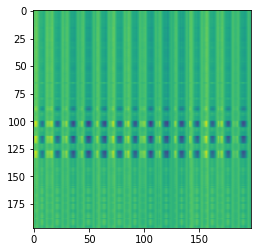

In [16]:
# Attention Matrix
attention_matrix = q @ kT
print(f'Attention matrix {attention_matrix.shape}')
plt.imshow(attention_matrix[3].detach().cpu().numpy())


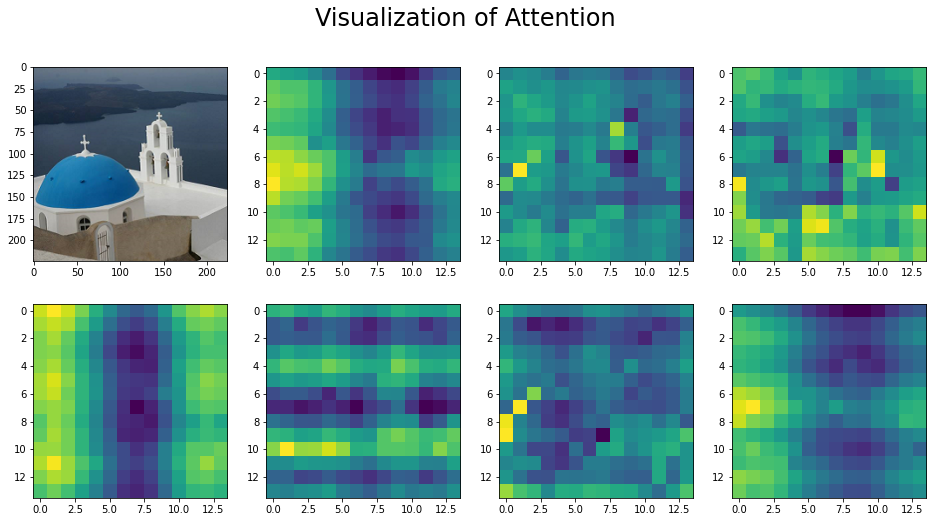

In [17]:
# visualize attention matrix
fig = plt.figure(figsize=(16,8))
fig.suptitle('Visualization of Attention', fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2,4,1)
ax.imshow(img)
for i in range(7): # visualize the 100th rows of attention matrices in th 0-7th heads
  attn_heatmap = attention_matrix[i, 100, 1:].reshape((14,14)).detach().cpu().numpy()
  ax = fig.add_subplot(2,4,i+2)
  ax.imshow(attn_heatmap)

## 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head. The 1000-dimension classification result is the output of the whole pipeline.

In [19]:
print(f'Classification head: {model.head}')
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
print(f'Inference result {imagenet_labels[result_label_id]}')

Classification head: Linear(in_features=768, out_features=1000, bias=True)
Inference result dome

